# imports

In [1]:
# ==========================
# 1. 標準庫
# ==========================
import sys
import os
import io
import json
import glob
import gc
import datetime
import random
from pathlib import Path
from typing import Dict, List, Union, Callable, Optional, Tuple
import inspect

# ==========================
# 2. 第三方套件
# ==========================
import numpy as np
import xarray as xr
import matplotlib.pylab as plt
from tqdm import trange
from IPython.display import clear_output, display, HTML
from scipy.ndimage import generic_filter

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as Optimizer
import torch.nn.init as init

from torchsummary import summary

# import cv2  # 如果影片相關再啟用

# ==========================
# 3. 專案設定
# ==========================
project_root = "C:/Users/GAI/Desktop/Scott/NCA_Research"
if project_root not in sys.path:
    sys.path.append(project_root)

# ==========================
# 4. IPython 魔法指令 (Jupyter 專用)
# ==========================
%reload_ext autoreload
%autoreload 2

# ==========================
# 5. 專案自定義函式庫
# ==========================
from core_utils.plotting import (
    plt_HWC_split_channels,
    plt_CFD_channels,
    plt_random_cfd_slice
)


# from core_utils.utils_io import (
#     np2pil,      # numpy → PIL Image
#     imwrite,     # 儲存圖像為檔案
#     imencode,    # 編碼圖像為 byte stream
#     im2url,      # 圖像轉 base64 URL（HTML 顯示用）
#     load_emoji,   # 載入 emoji 圖像
#     load_cfd_npy
# )

# from core_utils.utils_image import (
#     imshow,      # 在 notebook 顯示圖像
#     tile2d,      # 多圖拼接
#     zoom         # 放大圖像
# )

# from core_utils.utils_video import (
#     save_video,  # 批次輸出影片
#     VideoWriter  # 逐幀寫入影片（支援 context manager）
# )

# from core_utils.ops_tf_np import (
#     to_rgb,
#     to_rgba,
#     to_alpha,
#     crop_and_resize,
#     get_random_cfd_slices,
#     get_random_cfd_slices_pair
# )


from core_utils.viz_train import (
    viz_pool,
    viz_batch,
    viz_loss,
    viz_epochs
)


# 6. 實驗項目 utils 函式庫導入
from E4_PI_NCA.utils.helper import (
    to_HWC,
    print_tensor_stats,
    split_cases,
    get_output_path,
    plot_HW3,
    channels_to_rgb,
    print_loss_dict,
    sort_pool_by_mse,
    log_globals,
    check_tensor_nan_inf
)

clear_output()

# global params

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)
print("output path : ", get_output_path())
CHANNELS_NAMES = ["coordX","coordY","geo_mask", "topo", "uped", "vped", "Uped", "TKEped", "Tuwped"]
torch.set_default_device(DEVICE)

# dataset params
CASE_DATA = np.load("../dataset/all_cases.npz", allow_pickle=True)
FINAL_EPOCH_SIZE = 1024
IMG_SIZE = 64

# model params
CHANNELS = 24

# trainning params
TOTAL_EPOCHS = 5000
TRAIN_BATCH_SIZE = 32
EPOCH_ITEM_REPEAT_NUM = 2
EPOCH_POOL_SIZE = FINAL_EPOCH_SIZE // EPOCH_ITEM_REPEAT_NUM
# final epoch size = EPOCH_POOL_SIZE * EPOCH_ITEM_REPEAT_NUM
REPEAT_NUM_PER_EPOCH = 1
ROLLOUT_MIN = 1
ROLLOUT_MAX = 32

BC_CHANNELS = [0,1,2,3]
IC_CHANNELS = [4,5]

EARLYSTOP_PATIENCE = 100
EARLYSTOP_DELTA = 1e-7

W_MSE = 1.0
W_OBSTACLE = 3.0
W_UVEL = 1.0

SAVE_INTERVAL = 200

Using device: cuda
output path :  ..\outputs\E4-4.2_UrbanTales_GrowthNCA_v4_20251007-172252


In [3]:
def set_global_seed(seed: int = 42) -> None:
    """
    設定 Python、NumPy、PyTorch 的隨機種子，確保結果可重現。

    Parameters
    ----------
    seed : int, optional
        隨機種子數值, 預設 42
    """
    # Python random
    random.seed(seed)

    # NumPy
    np.random.seed(seed)

    # PyTorch CPU
    torch.manual_seed(seed)

    # PyTorch CUDA (單GPU & 多GPU)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # 設定 cudnn 為 deterministic，確保卷積結果可重現
    #在 debug/開發階段可以先設為 deterministic=False, benchmark=True 來加速
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

    print(f"[INFO] Global seed set to {seed}")


set_global_seed(1234)

[INFO] Global seed set to 1234


# helper functions

In [4]:
def remove_empty_dirs(root_dir: str) -> None:
    """
    遞迴刪除 root_dir 下的所有空資料夾 (沒有檔案，也沒有非空子資料夾)

    Parameters
    ----------
    root_dir : str
        要清理的根目錄
    """
    for dirpath, dirnames, filenames in os.walk(root_dir, topdown=False):
        # 如果這個資料夾沒有檔案，且底下子資料夾也都被刪光
        if not dirnames and not filenames:
            try:
                os.rmdir(dirpath)
                print(f"Removed empty folder: {dirpath}")
            except OSError as e:
                print(f"Skip {dirpath}, error: {e}")
remove_empty_dirs(r"C:\Users\GAI\Desktop\Scott\NCA_Research\E4_PI_NCA")

Removed empty folder: C:\Users\GAI\Desktop\Scott\NCA_Research\E4_PI_NCA\dataset2
Removed empty folder: C:\Users\GAI\Desktop\Scott\NCA_Research\E4_PI_NCA\outputs\E4-4.2_UrbanTales_GrowthNCA_v4_20250925-195738
Removed empty folder: C:\Users\GAI\Desktop\Scott\NCA_Research\E4_PI_NCA\outputs\E4-4.2_UrbanTales_GrowthNCA_v4_20250925-195908
Removed empty folder: C:\Users\GAI\Desktop\Scott\NCA_Research\E4_PI_NCA\outputs\E4-4.2_UrbanTales_GrowthNCA_v4_20251007-172252
Removed empty folder: C:\Users\GAI\Desktop\Scott\NCA_Research\E4_PI_NCA\outputs\E4-4.4_UrbanTales_GNCA_growthAndRepair_20250930-134417
Removed empty folder: C:\Users\GAI\Desktop\Scott\NCA_Research\E4_PI_NCA\outputs\E4-4.4_UrbanTales_GNCA_growthAndRepair_20250930-134424


In [5]:
def get_rollout_times(epoch, max_epoch, min_n=1, max_n=8, scale=1.0):
    """
    scale > 1 → 增長更慢
    """
    ratio = max_n / min_n
    n = min_n * (ratio ** (epoch / (scale * max_epoch)))
    return min(max_n, int(round(n)))

In [6]:
def plt_acc_over_time(
    acc_list: List[np.ndarray],
    title: str = "Accuracy over time",
    ylabel: str = "Metric",
    smooth_window: int = 1,
    log_scale: bool = False
):
    """
    繪製多條 metric 隨時間變化折線圖。
    - 前面部分淡化 (alpha=0.05)
    - 後 10 條線漸層
    - 最後一條線加粗且用紅色
    """
    plt.figure(figsize=(8,5))
    
    n = len(acc_list)
    n_fade = max(0, n - 10)  # 前面需要淡化的數量
    for i, arr in enumerate(acc_list):
        if isinstance(arr, list):
            arr = np.array(arr)

        # 判斷線條顏色和粗細
        if i == n - 1:
            color = "red"
            linewidth = 2.0
            alpha = 1.0
        elif i < n_fade:
            color = "tab:blue"
            linewidth = 1.0
            alpha = 0.005
        else:
            # 後 10 條線漸層
            idx = i - n_fade
            alpha = 0.3 + 0.7 * (idx / 9)  # 0.3~1.0
            color = "tab:blue"
            linewidth = 1.0

        # 原始線
        plt.plot(
            range(1, len(arr)+1), arr,
            color=color, alpha=alpha,
            linewidth=linewidth,
            label=f"Run {i+1}" if i == n-1 else None
        )

        # 平滑線
        if smooth_window > 1 and len(arr) >= smooth_window:
            smooth_values = np.convolve(arr, np.ones(smooth_window)/smooth_window, mode='valid')
            plt.plot(
                range(1, len(smooth_values)+1), smooth_values,
                color=color, alpha=alpha, linestyle='--',
                linewidth=linewidth
            )

    plt.xlabel("Step")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    if log_scale:
        plt.yscale('log')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [7]:
def process_case_data_to_tensor_list(
    case_data: Union[np.ndarray, np.lib.npyio.NpzFile, list] = CASE_DATA,
    channels_n: int = CHANNELS,
) -> List[torch.Tensor]:
    """
    將整個 case_data 轉成 list of 0-1 torch.Tensor，shape = (channels_n, H, W)
    支援輸入 np.ndarray (B,C,H,W), npzfile 或 list of arrays
    """
    case_list = []

    # 將 npzfile 或單一 array 轉成 list of arrays
    if isinstance(case_data, np.lib.npyio.NpzFile):
        keys = list(case_data.files)
        arrays = [case_data[k] for k in keys]
    elif isinstance(case_data, np.ndarray):
        if case_data.ndim == 4:  # B,C,H,W
            arrays = [case_data[i] for i in range(case_data.shape[0])]
        else:  # C,H,W
            arrays = [case_data]
    elif isinstance(case_data, list):
        arrays = case_data
    else:
        raise ValueError(f"Unsupported case_data type: {type(case_data)}")

    for arr in arrays:
        if isinstance(arr, torch.Tensor):
            arr = arr.cpu().numpy()
        else:
            arr = arr.astype(np.float32)

        C, H, W = arr.shape
        # 補零到目標 channels
        if C < channels_n:
            pad = np.zeros((channels_n - C, H, W), dtype=np.float32)
            arr = np.concatenate([arr, pad], axis=0)

        case_tensor = torch.tensor(arr, dtype=torch.float32, device=DEVICE)
        case_list.append(case_tensor)

    return case_list

In [8]:
all_cases = process_case_data_to_tensor_list()

check_tensor_nan_inf(all_cases)

# for case in all_cases:
    # print_tensor_stats(case,max_C=10)
TRAIN_CASES, EVAL_CASES, TEST_CASES = split_cases(
    all_cases, train_ratio=0.7, eval_ratio=0.2, test_ratio=0.1
)
print(len(TRAIN_CASES), len(EVAL_CASES), len(TEST_CASES))

15 4 3


## create_epoch_pool

In [9]:
def create_epoch_pool(
    train_case_list: List[torch.Tensor] = TEST_CASES,
    eval_case_list: Optional[List[torch.Tensor]] = EVAL_CASES,
    test_case_list: Optional[List[torch.Tensor]] = TEST_CASES,
    item_pool_repeats: int = EPOCH_ITEM_REPEAT_NUM,
    poolsize: int = EPOCH_POOL_SIZE,
    hw_size: int = IMG_SIZE,
    mode: str = "train",  # 'train', 'eval', 'test'
    eval_full_image_prob: float = 0.1,  # 評估時使用 full image 的機率
) -> torch.Tensor:
    """
    從指定的 case list 隨機生成一個 pool，每個樣本為裁剪的子區域或 full image。

    參數
    ----------
    train_case_list : List[torch.Tensor]
        訓練 case，每個 shape=(channels_n,H,W)
    eval_case_list : Optional[List[torch.Tensor]], default None
        驗證 case，每個 shape=(channels_n,H,W)，mode='eval' 才會使用
    test_case_list : Optional[List[torch.Tensor]], default None
        測試 case，每個 shape=(channels_n,H,W)，mode='test' 才會使用
    poolsize : int, default EPOCH_POOL_SIZE
        pool 中樣本數量
    hw_size : int, default IMG_SIZE
        裁剪區域大小，訓練模式固定使用
    mode : str, default 'train'
        模式：'train', 'eval', 'test'
    eval_full_image_prob : float, default 0.5
        評估模式時使用 full image 的機率

    回傳
    ----------
    torch.Tensor
        shape = (poolsize, channels_n, h_crop, w_crop)
        測試模式直接使用 full image
    """
    # 選擇對應 case list
    if mode == "train":
        case_list = train_case_list
    elif mode == "eval":
        if eval_case_list is None:
            raise ValueError("mode='eval' 需要提供 eval_case_list")
        case_list = eval_case_list
        poolsize = 1
    elif mode == "test":
        if test_case_list is None:
            raise ValueError("mode='test' 需要提供 test_case_list")
        case_list = test_case_list
        poolsize = 1  # 測試模式固定只取 1 個 sample
    else:
        raise ValueError(f"未知 mode='{mode}'，請選擇 'train', 'eval', 'test'")

    B = len(case_list)
    C, H, W = case_list[0].shape
    pool = []
    eval_fullsize_possibilities = np.random.rand()
    eval_size = hw_size if hw_size == H else np.random.randint(hw_size, H)
    # rand = +np.random.randint(-16, 16)
    for _ in range(poolsize):
        # 隨機選一個 case
        b_idx = np.random.randint(0, B)
        arr_tensor = case_list[b_idx]

        # 決定裁剪大小
        if mode == "train":
            hw_crop = hw_size
        elif mode == "eval":
            # 隨機裁剪或使用 full image
            if eval_fullsize_possibilities < eval_full_image_prob:
                hw_crop = H  # full image
            else:
                hw_crop = eval_size
        else:  # test
            hw_crop = H  # full image
        # hw_crop = hw_size
        # 隨機裁剪起始位置
        h_start = 0 if hw_crop == H else np.random.randint(0, H - hw_crop + 1)
        w_start = 0 if hw_crop == W else np.random.randint(0, W - hw_crop + 1)
        sub = arr_tensor[:, h_start : h_start + hw_crop, w_start : w_start + hw_crop]

        pool.append(sub)

    pool_tensor = torch.stack(
        pool, dim=0
    )  # shape = (poolsize, channels_n, hw_crop, hw_crop)

    # 複製 item pool
    if mode == "train":
        pool_tensor = pool_tensor.repeat((item_pool_repeats, 1, 1, 1))

    return pool_tensor

## init_X

In [10]:
def init_X(target: torch.Tensor) -> torch.Tensor:
    """
    根據 target 初始化 X，形狀相同 (CHW 或 BCHW)。

    邏輯：
    - channel 0 當作 mask
    - channel 0~6 = mask
    - channel >= 7 = 0

    Parameters
    ----------
    target : torch.Tensor
        shape = (C, H, W) 或 (B, C, H, W)

    Returns
    -------
    torch.Tensor
        與 target 同 shape 的 tensor
    """
    X = torch.zeros_like(target, dtype=torch.float32)

    # BCHW
    mask = (target[:, :6, :, :]).float()
    X[:, :6, :, :] = mask 

    return X

# viz load data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.98548293..1.1718658].


Epoch pool shape: torch.Size([1024, 24, 64, 64])


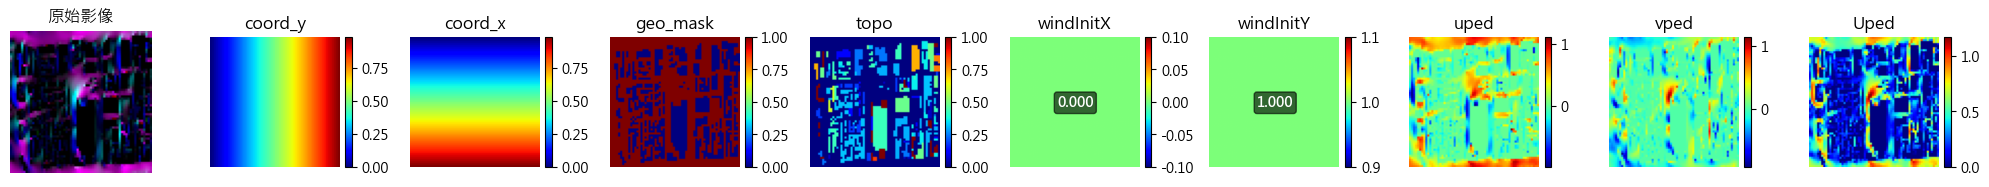

Epoch pool shape: torch.Size([1024, 24, 64, 64])


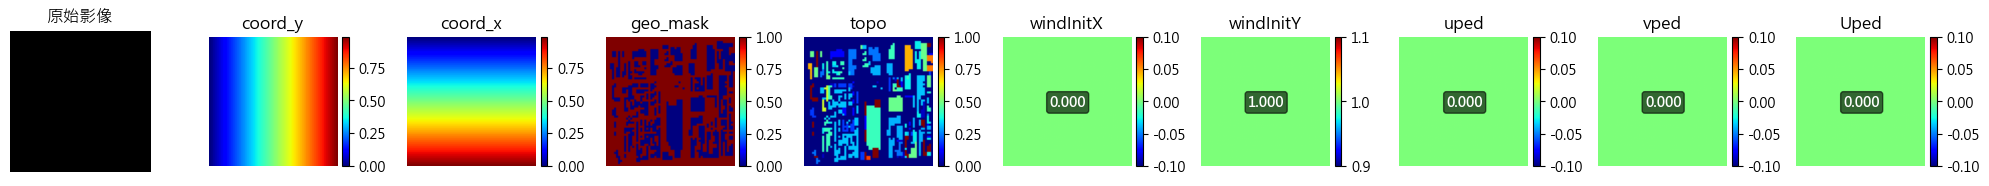

False

In [11]:
Y_pool = create_epoch_pool()
X_pool = init_X(Y_pool)
# print_tensor_stats(Y_pool,max_C=10)
# print_tensor_stats(X_pool,max_C=10)
# print("Epoch pool shape:", Y_pool.shape)  # (poolsize, hw_size, hw_size, 6)
# print_tensor_stats(Y_pool, "Y Pool")
print("Epoch pool shape:", Y_pool.shape)
plt_HWC_split_channels(to_HWC(Y_pool[0,:9,:,:]))
print("Epoch pool shape:", X_pool.shape)
plt_HWC_split_channels(to_HWC(X_pool[0,:9,:,:]))

check_tensor_nan_inf(X_pool, "X_pool")


# define Neural Net

## model

In [12]:
class CAModel(nn.Module):
    """
    Cellular Automata Model (Conv + perception kernels)
    """
    def __init__(self, channel_n: int = 16, kernel_count: int = 5, hidden_dim: int = 128):
        super().__init__()
        self.channel_n = channel_n
        self.kernel_count = kernel_count
        self.hidden_dim = hidden_dim

        # 建立 rule_block
        self.rule_block = self.build_rule_block(
            in_channels=self.channel_n * self.kernel_count,
            hidden_dim=self.hidden_dim,
            out_channels=self.channel_n,
            num_hidden_layers=1
        )

    def build_rule_block(self, in_channels: int, hidden_dim: int, out_channels: int, num_hidden_layers: int = 1) -> nn.Sequential:
        """
        建立 rule block 的 Conv + Tanh 結構
        """
        layers = [nn.Conv2d(in_channels, hidden_dim, kernel_size=3,padding="same"), nn.Tanh()]
        # layers.append(nn.Conv2d(hidden_dim, hidden_dim, kernel_size=1))
        # layers.append(nn.Tanh())
        # layers.append(nn.Conv2d(hidden_dim, hidden_dim, kernel_size=1))
        # layers.append(nn.Tanh())
        for _ in range(num_hidden_layers):
            layers.append(nn.Conv2d(hidden_dim, hidden_dim*2, kernel_size=1))
            layers.append(nn.Tanh())
            layers.append(nn.Conv2d(hidden_dim*2, hidden_dim, kernel_size=1))
            layers.append(nn.Tanh())
        layers.append(nn.Conv2d(hidden_dim, out_channels, kernel_size=1))  #, bias=False
        # layers.append(nn.Tanh())
        return nn.Sequential(*layers)

    def perchannel_conv(self, x: torch.Tensor, filters: torch.Tensor) -> torch.Tensor:
        """
        對每個 channel 做 depthwise convolution
        x: [B, C, H, W]
        filters: [filter_n, Hf, Wf]
        return: [B, C * filter_n, H, W]
        """
        b, ch, h, w = x.shape
        device = x.device
        filters = filters.to(device)
        y = x.reshape(b * ch, 1, h, w)
        y = F.pad(y, [1, 1, 1, 1], mode='circular')
        y = F.conv2d(y, filters[:, None])
        return y.reshape(b, -1, h, w)

    def perception(self, x: torch.Tensor) -> torch.Tensor:
        """
        定義感知 kernels: identity, sobel_x, sobel_y, laplacian
        """
        device = x.device
        ident = torch.tensor([[0.0, 0.0, 0.0],
                              [0.0, 1.0, 0.0],
                              [0.0, 0.0, 0.0]], device=device)
        sobel_x = torch.tensor([[-1.0, 0.0, 1.0],
                                [-2.0, 0.0, 2.0],
                                [-1.0, 0.0, 1.0]], device=device)
        lap = torch.tensor([[1.0, 2.0, 1.0],
                            [2.0, -12.0, 2.0],
                            [1.0, 2.0, 1.0]], device=device)
        lbm = torch.tensor([[1/36, 1/9, 1/36],
                            [1/9, 4/9, 1/9],
                            [1/36, 1/9, 1/36]], device=device)
        filters = torch.stack([ident, sobel_x, sobel_x.T, lap, lbm])
        return self.perchannel_conv(x, filters)
    

    def forward_pass(self, x: torch.Tensor) -> torch.Tensor:
        """
        單步更新
        """
        check_tensor_nan_inf(x,"model")
        y = self.perception(x)
        check_tensor_nan_inf(y,"model2")
        dx = self.rule_block(y)
        check_tensor_nan_inf(dx,"model3")
        mask = x[:, :6, :, :]  # 前6 channel 保留
        updated = x + dx * x[:, 2:3, :, :]
        check_tensor_nan_inf(updated,"model4")
        return torch.cat([mask, updated[:, 6:, :, :]], dim=1)

    def forward(self, x: torch.Tensor, n_times: int = 1) -> torch.Tensor:
        """
        多步迭代
        """
        for _ in range(n_times):
            x = self.forward_pass(x)
        return x

model = CAModel(channel_n=CHANNELS).to(DEVICE)
summary(model, (CHANNELS, IMG_SIZE, IMG_SIZE), device=DEVICE)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 64, 64]         138,368
              Tanh-2          [-1, 128, 64, 64]               0
            Conv2d-3          [-1, 256, 64, 64]          33,024
              Tanh-4          [-1, 256, 64, 64]               0
            Conv2d-5          [-1, 128, 64, 64]          32,896
              Tanh-6          [-1, 128, 64, 64]               0
            Conv2d-7           [-1, 24, 64, 64]           3,096
Total params: 207,384
Trainable params: 207,384
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.38
Forward/backward pass size (MB): 32.75
Params size (MB): 0.79
Estimated Total Size (MB): 33.92
----------------------------------------------------------------


## EarlyStop

In [13]:
class EarlyStopper:
    """
    Early stopping helper
    """
    def __init__(self, patience=EARLYSTOP_PATIENCE, min_delta=EARLYSTOP_DELTA):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = np.inf
        self.early_stop = False

    def step(self, loss):
        if loss + self.min_delta < self.best_loss:
            self.best_loss = loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        return self.early_stop


## epoch step

### train step

In [14]:
# ====== 訓練函式 ======
def train_one_epoch(
    epoch_count: int,
    model: nn.Module,
    optimizer: Optimizer,
    loss_fn: nn.Module,
    Y_pool: np.array,
    X_pool: np.array,
    train_batch_size: int = TRAIN_BATCH_SIZE,
    rollout_max: int = ROLLOUT_MAX,
    total_epochs: int = TOTAL_EPOCHS,
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    執行一個 epoch 的訓練迴圈，回傳最後一個 batch 的 loss 與對應資料。

    參數:
        model: nn.Module, 神經網路模型
        optimizer: PyTorch Optimizer
        loss_fn: nn.Module, 損失函數
        train_batch_size: int, 單次訓練的 batch 大小
        item_pool_repeats: int, 將 epoch pool 複製的次數
        repeats_per_epoch: int, 每個 epoch 重複迭代的次數
        rollout_min: int, 最小演化步數
        rollout_max: int, 最大演化步數

    回傳:
        tuple: (loss, Y_batch, X_batch, X_pred)
            - loss: torch.Tensor, 最後一個 batch 的 loss
            - Y_batch: torch.Tensor, 目標 batch
            - X_batch: torch.Tensor, 模型輸入 batch
            - X_pred: torch.Tensor, 模型輸出 batch
    """
    model.train()

    # 隨機挑一個 batch
    idx = torch.randint(0, len(Y_pool) - train_batch_size + 1, (1,))
    Y_batch = Y_pool[idx : idx + train_batch_size].to(DEVICE)
    X_batch = X_pool[idx : idx + train_batch_size].to(DEVICE).clone()
    check_tensor_nan_inf([Y_batch,X_batch],"train step1")
    with torch.no_grad():
        batch_count = len(X_batch)
        X_batch[-batch_count // 8 :] = init_X(X_batch[-batch_count // 8 :])
    check_tensor_nan_inf([Y_batch,X_batch],"train step2")
    # 隨機決定演化步數
    rollout_steps = get_rollout_times(
        epoch_count, max_epoch=total_epochs, max_n=rollout_max, scale=1
    )

    # 前向傳播
    X_pred = model(X_batch, n_times=rollout_steps)
    check_tensor_nan_inf([X_pred],"train step3")
    # 更新pool
    X_pool[idx : idx + train_batch_size] = X_pred
    check_tensor_nan_inf([X_pool],"train step4")

    # 計算 loss 並反向傳播
    check_tensor_nan_inf([X_pred,Y_batch],"train step5")
    loss_dict = loss_fn(X_pred, Y_batch)
    check_tensor_nan_inf([loss_dict],"train step6")
    total_loss = sum(loss_dict.values())

    # 反向傳播更新梯度
    optimizer.zero_grad()
    total_loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()

    batch_dict = {
        "Y": Y_batch,
        "X0": X_batch,
        "X1": X_pred,
        "diff": Y_batch - X_pred,
    }

    return loss_dict, batch_dict

### eval step

In [15]:
def evaluate_one_epoch(
    model: torch.nn.Module,
    loss_fn: Callable[[torch.Tensor, torch.Tensor], Dict[str, torch.Tensor]],
    metric_fn: Callable[[torch.Tensor, torch.Tensor], Dict[str, torch.Tensor]] = None,
    rollout_steps: int = ROLLOUT_MAX,
) -> Tuple[Dict[str, torch.Tensor], Dict[str, torch.Tensor], np.ndarray]:
    """
    在測試集上做評估，計算平均 loss 與 metric。
    """
    model.eval()
    total_loss_list = []
    X_batch_list = []
    X_pred_list = []
    metrics_list = []

    # 建立 epoch 的子區域池
    Y_batch = create_epoch_pool(mode="eval").to(DEVICE)  # torch.Size([1, 32, 64, 64])
    X_batch = init_X(Y_batch)

    check_tensor_nan_inf([Y_batch,X_batch],"inside eval")

    rollout_steps = 20
    for _ in range(rollout_steps):
        X_batch_list.append(X_batch.clone())
        check_tensor_nan_inf([X_batch_list,X_batch],"inside eval2")
        X_batch = model(X_batch, n_times=1)
        X_pred_list.append(X_batch.clone())

        # 計算 loss
        check_tensor_nan_inf([Y_batch,X_batch],"inside eval3")
        loss_dict = loss_fn(X_batch, Y_batch)
        check_tensor_nan_inf(loss_dict,"inside eval4")
        total_loss = sum(loss_dict.values())
        total_loss_list.append(total_loss)

        # 計算 metric
        if metric_fn is not None:
            acc_metric = metric_fn(X_batch, Y_batch)
            metrics_list.append(acc_metric)

    x0 = torch.cat(X_batch_list, dim=0)
    x1 = torch.cat(X_pred_list, dim=0)
    y = Y_batch.repeat((rollout_steps, 1, 1, 1))

    metrics_array = np.array(metrics_list)

    batch_dict = {
        "Y": y,
        "X0": x0,
        "X1": x1,
        "diff": y - x1,
    }

    return loss_dict, batch_dict, metrics_array


## training loop

In [16]:

def save_checkpoint(model, optimizer, epoch, path):
    torch.save(
        {
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
        },
        path,
    )

In [17]:
from torch.optim.lr_scheduler import _LRScheduler
def run_training(
    model: nn.Module,
    optimizer: Optimizer,
    loss_fn: Callable[[torch.Tensor, torch.Tensor], Dict[str, torch.Tensor]],
    metric_fn: Callable[[torch.Tensor, torch.Tensor], Dict[str, torch.Tensor]] = None,
    total_epochs: int = TOTAL_EPOCHS,
    lr_sched: Optional[_LRScheduler] = None,
) -> None:
    
    train_loss_log: list[float] = []
    eval_loss_log: list[float] = []
    eval_loss = 0
    eval_metrics: List[np.ndarray] = []
    OutPath = get_output_path()

    early_stopper = EarlyStopper()
    Y_Pool = create_epoch_pool(mode="train").to(DEVICE)
    X_Pool = init_X(Y_Pool)
    
    check_tensor_nan_inf([Y_Pool,X_Pool],"init_check")

    for epoch in trange(total_epochs, desc="Training Epochs"):
        if (epoch + 1) % 500 == 0:
            Y_Pool = create_epoch_pool(mode="train").to(DEVICE)
            X_Pool = init_X(Y_Pool)
        # print(f"epoch {epoch} start ------------------------------------")
        # ===== Training step =====
        train_loss_dict, train_batch_dict = train_one_epoch(
            epoch, model, optimizer, loss_fn, Y_Pool, X_Pool
        )
        train_loss = sum(train_loss_dict.values())
        train_loss_log.append(train_loss.item())

        if lr_sched is not None:
            lr_sched.step()

        # ===== Eval step =====
        with torch.no_grad():
            check_tensor_nan_inf([X_Pool,Y_Pool],"eval check")
            X_Pool, Y_Pool = sort_pool_by_mse(X_Pool, Y_Pool)
            check_tensor_nan_inf([X_Pool,Y_Pool],"eval check2")
            eval_loss_dict, eval_batch_dict, eval_metric = evaluate_one_epoch(
                model, loss_fn, metric_fn
            )
            check_tensor_nan_inf([eval_loss_dict,eval_batch_dict,eval_metric],"eval check3")
            eval_metrics.append(eval_metric)
            if len(eval_metrics) > 1000:  # 或自己決定長度
                eval_metrics.pop(0)

            eval_loss = sum(eval_loss_dict.values())
            eval_loss_log.append(eval_loss.item())


        # ===== Visualization & Logging =====
        if (epoch + 1) % 50 == 0:
            clear_output(wait=True)
            print_loss_dict(train_loss_dict, eval_loss_dict)
            viz_loss(train_loss_log, eval_loss_log,
                     log_scale=True, window=total_epochs // 20)
            plt_acc_over_time(eval_metrics, title="L2 Metric", ylabel="L2 Error")
            viz_epochs(train_batch_dict)
            viz_epochs(eval_batch_dict)

        # ===== Checkpoint =====
        if (epoch + 1) % SAVE_INTERVAL == 0:
            save_checkpoint(model, optimizer, epoch+1,
                            f"{OutPath}/checkpoint_epoch_{epoch+1}.pth")

        # ===== Early stopping =====
        if early_stopper.step(eval_loss)and epoch >1000:
            print(f"Early stopping at epoch {epoch}")
            break
        # ---- Early stop if train loss is NaN ----
        check_tensor_nan_inf([train_loss_dict,eval_loss_dict],"loss_dict check")
        if torch.isnan(train_loss):
            print_loss_dict(train_loss_dict, eval_loss_dict)
            print(f"NaN detected in train loss at epoch {epoch}, stopping training.")
            break

        # ===== Memory cleanup 每個 epoch 強制釋放 =====
        del train_loss_dict, train_batch_dict, eval_loss_dict, eval_batch_dict, eval_metric
        torch.cuda.empty_cache()
        gc.collect()

    # ===== Final save =====
    viz_loss(train_loss_log, eval_loss_log,
             log_scale=True, window=total_epochs // 20,
             save_path=f"{OutPath}/loss")
    log_globals(globals(), log_dir=OutPath)
    save_checkpoint(model, optimizer, total_epochs, f"{OutPath}/model_Final.pth")
    return OutPath


## loss function

In [18]:
def divergence_loss(u, v):
    # u, v shape: [B, 1, H, W]  (速度分量)
    du_dx = torch.gradient(u, dim=-1)[0]  # ∂u/∂x
    dv_dy = torch.gradient(v, dim=-2)[0]  # ∂v/∂y
    div = du_dx + dv_dy
    return torch.mean(div**2)  # L2 loss on divergence


def data_mse_loss(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    """
    計算 x 與 y 之間的 MSE loss
    """
    mse = nn.MSELoss()
    x = x[:, 6:11, :, :]  # 只取前 7 個 channel
    y = y[:, 6:11, :, :]
    loss = mse(x, y)

    return loss


def obstacle_loss(x: torch.Tensor) -> torch.Tensor:
    """
    檢查 obstacle cell (mask=0) 內，其他 channel 的值應該趨近於 0

    Args:
        x: Tensor [B, C, H, W], channel 0 = geo_mask (1=air, 0=object)

    Returns:
        torch.Tensor: scalar loss
    """
    mask = x[:, 2:3, ...]  # [B, 1, H, W]
    phys = x[:, 6:9, ...]  # [B, 7, H, W] 取前 7 個物理量通道

    obj_mask = 1.0 - mask  # object cell = 1, air = 0
    masked_phys = phys * obj_mask  # 只保留物體內的值
    loss = torch.mean(masked_phys**2)
    return loss


def fft_loss(x: torch.Tensor, y: torch.Tensor, norm: str = "L2") -> torch.Tensor:
    """
    Compute per-channel FFT loss between x and y.

    Parameters
    ----------
    x, y : torch.Tensor
        Input and target tensors, shape = (B, C, H, W)
    norm : str
        'L1' or 'L2' for difference metric

    Returns
    -------
    torch.Tensor
        Scalar loss
    """
    # FFT: compute 2D FFT per channel
    X_fft = torch.fft.fft2(x[:, 6:9, ...], norm="ortho")  # (B, C, H, W), complex
    Y_fft = torch.fft.fft2(y[:, 6:9, ...], norm="ortho")

    # Compute magnitude difference
    diff = torch.abs(X_fft - Y_fft)  # magnitude difference

    if norm.upper() == "L1":
        loss = diff.mean()
    elif norm.upper() == "L2":
        loss = (diff**2).mean()
    else:
        raise ValueError("norm should be 'L1' or 'L2'")

    return loss


def Uvel_loss(x: torch.Tensor):
    Uped_cal = torch.sqrt(x[:, 6:7, ...] ** 2 + x[:, 7:8, ...] ** 2 + 1e-8)  # (b,c,H,W)
    diff = torch.abs(x[:, 8:9, ...] - Uped_cal) 
    loss = (diff**2).mean()
    return loss

def custom_loss(x: torch.Tensor, y: torch.Tensor) -> dict:
    return {
        "mse_loss": W_MSE * data_mse_loss(x, y)/1e-2,
        # "obstacle_loss": W_OBSTACLE * obstacle_loss(x)/1e-4,
        # "Uvel_loss": W_UVEL * Uvel_loss(x)/1e-2,
    }

## metric function

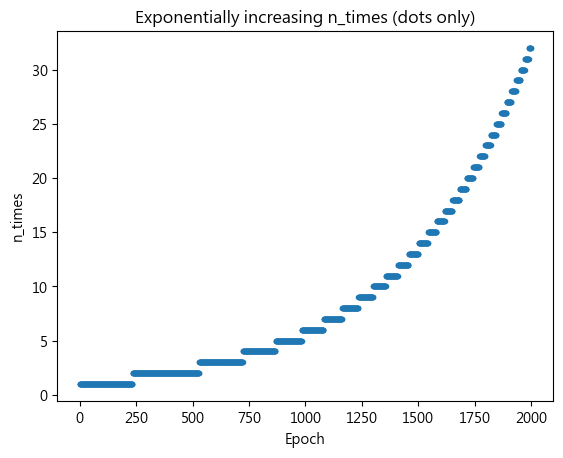

In [19]:
# 範例畫圖
xs = [get_rollout_times(e, max_epoch=2000,max_n=32, scale=1) for e in range(2000)]

fig, ax = plt.subplots()
ax.plot(xs, 'o', markersize=3)  # 只畫點
ax.set_xlabel("Epoch")
ax.set_ylabel("n_times")
ax.set_title("Exponentially increasing n_times (dots only)")
plt.show()

In [20]:
def acc_metric(
    pred: torch.Tensor,
    target: torch.Tensor,
    metric_type: str = "L2",
) -> np.array:
    """
    計算模型精度 metric, 支持用 pred 的第0 channel作為 mask.

    Parameters
    ----------
    pred : torch.Tensor
        模型預測, shape = (B, C, H, W)
    target : torch.Tensor
        Ground truth, shape = (B, C, H, W)
    use_pred_mask : bool
        是否用 pred 的第0 channel作為 mask (1 = 計算, 0 = 忽略)
    metric_type : str
        "L1", "L2", "relative"

    Returns
    -------
    torch.Tensor
        scalar metric
    """

    if metric_type.upper() == "L1":
        return torch.mean(torch.abs(pred - target)).detach().cpu().numpy()
    elif metric_type.upper() == "L2":
        return torch.mean((pred - target) ** 2).detach().cpu().numpy()
    elif metric_type.lower() == "relative":
        return torch.mean(torch.abs(pred - target) / (torch.abs(target) + 1e-8)).detach().cpu().numpy()
    else:
        raise ValueError("metric_type should be 'L1', 'L2', or 'relative'")

# main process

In [21]:
#this cell for debuging
Y_batch = create_epoch_pool(mode="eval").to(DEVICE)  # torch.Size([1, 32, 64, 64])
X_batch = init_X(Y_batch)
loss_dict = custom_loss(Y_batch, Y_batch)
check_tensor_nan_inf(loss_dict,"test")
print_loss_dict(loss_dict)
loss_dict = custom_loss(X_batch, Y_batch)
check_tensor_nan_inf(loss_dict,"test1")
print_loss_dict(loss_dict)

model = CAModel(channel_n=CHANNELS).to(DEVICE)

check_tensor_nan_inf(X_batch,"test2")
for i in range(100):
    X_batch = model(X_batch)
    # if i%20==0:
        # plt_HWC_split_channels(to_HWC(X_batch[0,:9,:,:]))
    check_tensor_nan_inf(X_batch,f"test3_{i}")


Train Losses:
mse_loss: 0.0000 | 
Train Losses:
mse_loss: 6.8261 | 


Train Losses:
mse_loss: 2.5067 | 
Eval Losses:
mse_loss: 13.8087 | 


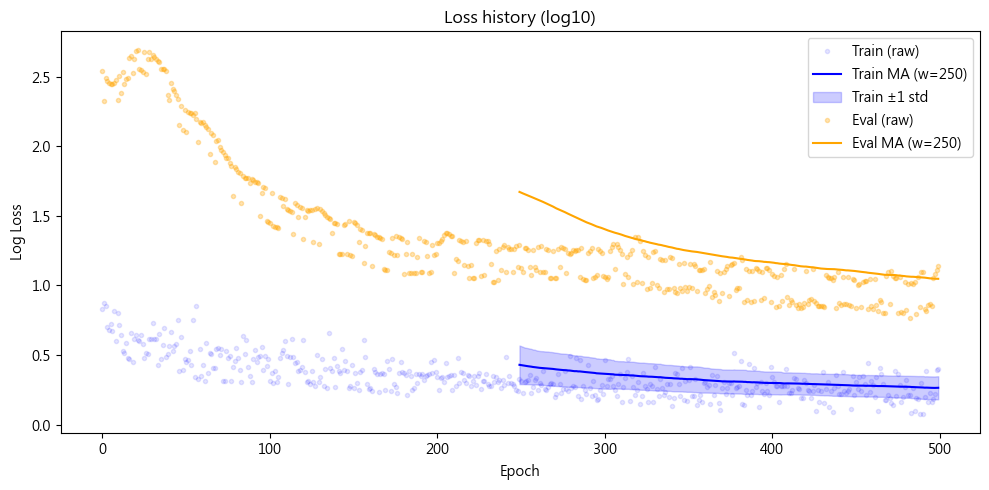

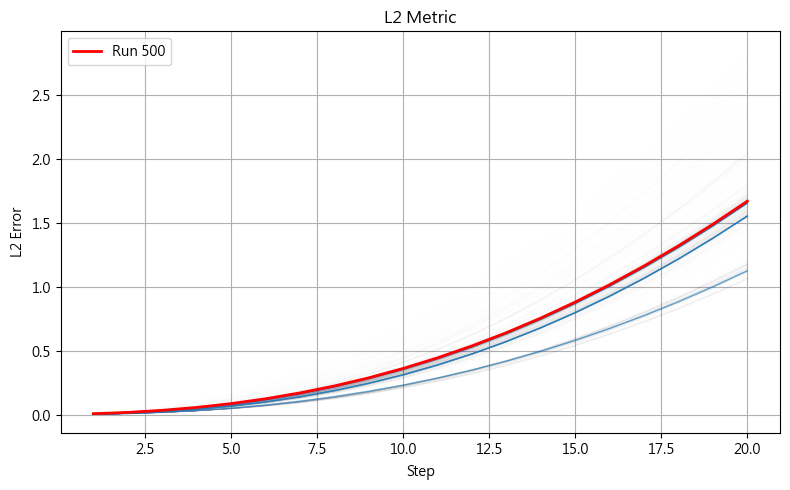

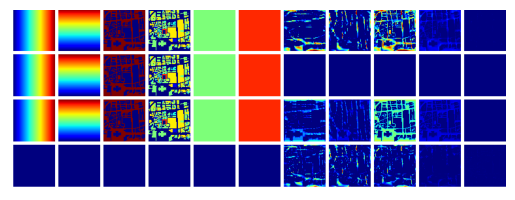

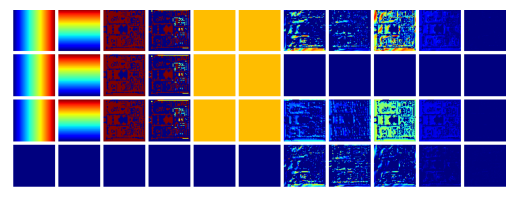

Training Epochs:  11%|█         | 545/5000 [03:44<30:36,  2.43it/s]


KeyboardInterrupt: 

In [23]:
model = CAModel(channel_n=CHANNELS).to(DEVICE)
optimizer = Optimizer.Adam(model.parameters(), lr=1e-4)
# optimizer = Optimizer.LBFGS(model.parameters(), lr=1.0, max_iter=500, history_size=50)
# lr_sched = torch.optim.lr_scheduler.MultiStepLR(optimizer, [300, 600], 0.3)
lr_sched = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.5)

model_path = run_training(model, optimizer, loss_fn=custom_loss, metric_fn=acc_metric, lr_sched=lr_sched)

# test model

In [ ]:
import torch
import numpy as np
import os
import imageio
from PIL import Image  # 用來 resize

output_dir = "temp_frames"
os.makedirs(output_dir, exist_ok=True)

# --- 初始化資料 ---
Y_batch = create_epoch_pool(mode="eval").to(DEVICE)  # [1, 32, 64, 64]
X_batch = init_X(Y_batch)  # [batch, channel, H, W]

# 假設模型已經載入並設定 eval
load_model = CAModel(channel_n=CHANNELS).to(DEVICE)
load_model.load_state_dict(torch.load(f"{model_path}/model.pth"))
load_model.eval()

rollout_steps = 50
frames = []
target_size = (1024, 1024)  # (W, H)

for t in range(rollout_steps):
    # 每步 rollout
    X_batch = load_model(X_batch, n_times=1)

    # 取第一個 batch 的前三個 channel作 RGB
    x_np = X_batch[0, 4:7].detach().cpu().numpy()  # shape: [3, H, W]
    frame = np.transpose(x_np, (1, 2, 0))         # shape: [H, W, 3]
    frame = np.clip(frame, 0, 1)                  # 確保值在 0~1
    frame_uint8 = (frame * 255).astype(np.uint8)

    # resize
    img = Image.fromarray(frame_uint8)
    img = img.resize(target_size, resample=Image.BILINEAR)
    frame_resized = np.array(img)

    # 選擇是否存單張 PNG
    frame_path = os.path.join(output_dir, f"{t:03d}.png")
    imageio.imwrite(frame_path, frame_resized)

    # 累積成影片幀
    frames.append(frame_resized)

# 儲存成 mp4
video_path = f"{model_path}/output.mp4"
imageio.mimsave(video_path, frames, fps=3)
print("Saved mp4:", video_path)


FileNotFoundError: [Errno 2] No such file or directory: '..\\outputs\\E4-4.2_UrbanTales_GrowthNCA_v4_20250925-194936/model.pth'